In [1]:
import pandas as pd 
from sklearn.model_selection import learning_curve, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt 
import seaborn as sns

In [2]:
# 数据加载
data = pd.read_csv('./UCI_Credit_Card.csv')

In [3]:
# 数据探索
print(data.shape)  # 查看数据集大小
print(data.describe())  # 数据集概览

(30000, 25)
                 ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904  

In [4]:
# 查看下一个月违约率的情况
next_month = data['default.payment.next.month'].value_counts()
next_month

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

In [11]:
import matplotlib

matplotlib.matplotlib_fname()

'/Users/admin/Workspace/DataDev/venv/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'

<AxesSubplot:title={'center':'信用卡违约率客户\n （违约：1，守约：0）'}, xlabel='default.payment.next.month', ylabel='values'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/Users/admin/Workspace/DataDev/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/admin/Workspace/DataDev/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/admin/Workspace/DataDev/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21345 (\N{CJK UNIFIED IDEOGRAPH-5361}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/admin/Workspace/DataDev/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36829 (\N{CJK UNIFIED IDEOGRA

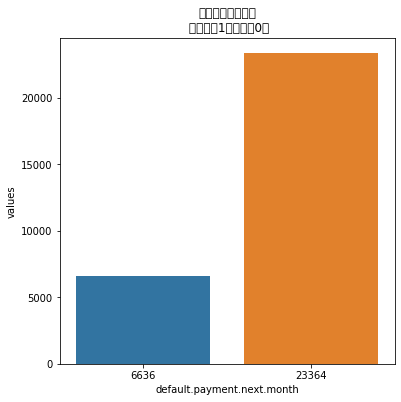

In [5]:
df = pd.DataFrame({'default.payment.next.month': next_month, 'values': next_month.values})
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.figure(figsize=(6, 6))
plt.title('信用卡违约率客户\n （违约：1，守约：0）')
sns.set_color_codes('pastel')
sns.barplot(x='default.payment.next.month', y='values', data=df)

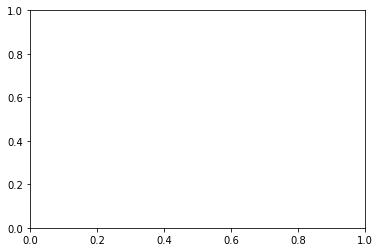

In [6]:
locs, labels = plt.xticks()
plt.show()

In [7]:
# 特征选择、去掉 ID 字段、最后一个结果字段即可
data.drop(['ID'], inplace=True, axis=1)  # ID 字段没有用
target = data['default.payment.next.month'].values
columns = data.columns.tolist()
columns.remove('default.payment.next.month')
features = data[columns].values
# 30% 作为测试集、其余作为训练集
train_x, test_x, train_y, test_y = train_test_split(
    features, target, 
    test_size=0.30, 
    stratify=target, 
    random_state=1)

In [8]:
# 构造各种分类器
classifiers = [
    SVC(random_state=1, kernel='rbf'),
    DecisionTreeClassifier(random_state=1, criterion='gini'),
    RandomForestClassifier(random_state=1, criterion='gini'),
    KNeighborsClassifier(metric='minkowski'),
]
# 分类器名称
classifier_names = [
    'svc',
    'decisiontreeclassifier',
    'randomforestclassifier',
    'kneighborsclassifier',
]
# 分类器参数
classifier_param_grid = [
    {'svc__C':[1], 'svc__gamma':[0.01]},
    {'decisiontreeclassifier__max_depth':[6,9,11]},
    {'randomforestclassifier__n_estimators':[3,5,6]} ,
    {'kneighborsclassifier__n_neighbors':[4,6,8]},
]

In [9]:
# 对具体的分类器进行 GridSearchCV 参数调优
def GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, param_grid, score='accuracy'):
    response = {}
    gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = score)
    # 寻找最优的参数和最优的准确率参数
    search = gridsearch.fit(train_x, train_y)
    print('GridSearchCV 最优参数：', search.best_params_)
    print('GridSearchCV 最优分数：%0.4lf' %search.best_score_)
    predict_y = gridsearch.predict(test_x)
    print('准确率 %0.4lf' %accuracy_score(test_y, predict_y))
    response['predict_y'] = predict_y
    response['accuracy_score'] = accuracy_score(test_y, predict_y)
    return response

In [10]:
for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (model_name, model)
    ])
    result = GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, model_param_grid, score='accuracy')

GridSearchCV 最优参数： {'svc__C': 1, 'svc__gamma': 0.01}
GridSearchCV 最优分数：0.8186
准确率 0.8172
GridSearchCV 最优参数： {'decisiontreeclassifier__max_depth': 6}
GridSearchCV 最优分数：0.8208
准确率 0.8113
GridSearchCV 最优参数： {'randomforestclassifier__n_estimators': 6}
GridSearchCV 最优分数：0.8004
准确率 0.7994
GridSearchCV 最优参数： {'kneighborsclassifier__n_neighbors': 8}
GridSearchCV 最优分数：0.8040
准确率 0.8036
